In [1]:
import h5py
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import pickle


In [2]:
matFilename = '2017-05-12_batchdata_updated_struct_errorcorrect.mat'
f = h5py.File(matFilename)

In [3]:
list(f.keys())

['#refs#', '#subsystem#', 'batch', 'batch_date']

In [4]:
batch = f['batch']

In [5]:
list(batch.keys())

['Vdlin',
 'barcode',
 'channel_id',
 'cycle_life',
 'cycles',
 'policy',
 'policy_readable',
 'summary']

In [6]:
import pandas as pd
df=pd.DataFrame(batch.keys() )

In [7]:
df

,0
0,Vdlin
1,barcode
2,channel_id
3,cycle_life
4,cycles
5,policy
6,policy_readable
7,summary


In [8]:
print("Keys under batch :", list(batch.keys())) 

Keys under batch : ['Vdlin', 'barcode', 'channel_id', 'cycle_life', 'cycles', 'policy', 'policy_readable', 'summary']


In [9]:
f = h5py.File(matFilename , 'r')

batch = f['batch']

num_cells = batch['summary'].shape[0]
bat_dict = {}

for i in range(num_cells):
    cl = f[batch['cycle_life'][i, 0]][()].item()
    policy = f[batch['policy_readable'][i, 0]][()].tobytes()[::2].decode()
    summary_IR = np.hstack([f[batch['summary'][i, 0]]['IR'][0,:][()].flatten()])
    summary_QC = np.hstack([f[batch['summary'][i, 0]]['QCharge'][0,:][()].flatten()])
    summary_QD = np.hstack([f[batch['summary'][i, 0]]['QDischarge'][0,:][()].flatten()])
    summary_TA = np.hstack([f[batch['summary'][i, 0]]['Tavg'][0,:][()].flatten()])
    summary_TM = np.hstack([f[batch['summary'][i, 0]]['Tmin'][0,:][()].flatten()])
    summary_TX = np.hstack([f[batch['summary'][i, 0]]['Tmax'][0,:][()].flatten()])
    summary_CT = np.hstack([f[batch['summary'][i, 0]]['chargetime'][0,:][()].flatten()])
    summary_CY = np.hstack([f[batch['summary'][i, 0]]['cycle'][0,:][()].flatten()])
    summary = {
        'IR': summary_IR, 'QC': summary_QC, 'QD': summary_QD, 
        'Tavg': summary_TA, 'Tmin': summary_TM, 'Tmax': summary_TX, 
        'chargetime': summary_CT, 'cycle': summary_CY
    }
    cycles = f[batch['cycles'][i, 0]]
    cycle_dict = {}
    for j in range(cycles['I'].shape[0]):
        I = f[cycles['I'][j, 0]][()].flatten()
        Qc = f[cycles['Qc'][j, 0]][()].flatten()
        Qd = f[cycles['Qd'][j, 0]][()].flatten()
        Qdlin = f[cycles['Qdlin'][j, 0]][()].flatten()
        T = f[cycles['T'][j, 0]][()].flatten()
        Tdlin = f[cycles['Tdlin'][j, 0]][()].flatten()
        V = f[cycles['V'][j, 0]][()].flatten()
        dQdV = f[cycles['discharge_dQdV'][j, 0]][()].flatten()
        t = f[cycles['t'][j, 0]][()].flatten()
        cd = {
            'I': I, 'Qc': Qc, 'Qd': Qd, 'Qdlin': Qdlin, 
            'T': T, 'Tdlin': Tdlin, 'V': V, 'dQdV': dQdV, 't': t
        }
        cycle_dict[str(j)] = cd
    
    cell_dict = {
        'cycle_life': cl,
        'charge_policy': policy,
        'summary': summary,
        'cycles': cycle_dict
    }
    key = 'b1c' + str(i)
    bat_dict[key] = cell_dict


In [10]:
bat_dict.keys()

dict_keys(['b1c0', 'b1c1', 'b1c2', 'b1c3', 'b1c4', 'b1c5', 'b1c6', 'b1c7', 'b1c8', 'b1c9', 'b1c10', 'b1c11', 'b1c12', 'b1c13', 'b1c14', 'b1c15', 'b1c16', 'b1c17', 'b1c18', 'b1c19', 'b1c20', 'b1c21', 'b1c22', 'b1c23', 'b1c24', 'b1c25', 'b1c26', 'b1c27', 'b1c28', 'b1c29', 'b1c30', 'b1c31', 'b1c32', 'b1c33', 'b1c34', 'b1c35', 'b1c36', 'b1c37', 'b1c38', 'b1c39', 'b1c40', 'b1c41', 'b1c42', 'b1c43', 'b1c44', 'b1c45'])

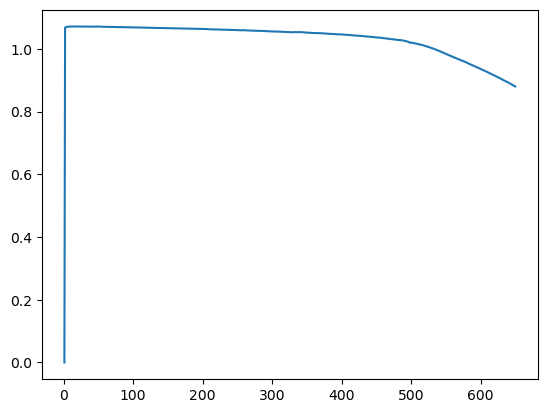

In [11]:
plt.plot(bat_dict['b1c43']['summary']['cycle'], bat_dict['b1c43']['summary']['QD'])

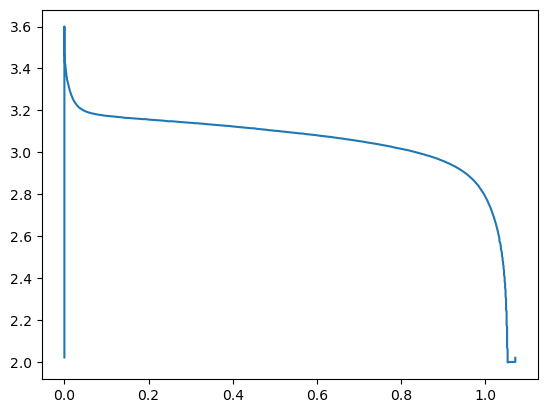

In [12]:
plt.plot(bat_dict['b1c43']['cycles']['10']['Qd'], bat_dict['b1c43']['cycles']['10']['V'])

In [13]:
print("Keys under batch :", list(batch.keys())) 

Keys under batch : ['Vdlin', 'barcode', 'channel_id', 'cycle_life', 'cycles', 'policy', 'policy_readable', 'summary']


In [14]:
import re
import pandas as pd

def parse_policy(policy_str):
    """Extracts C1, Q1, C2 from a string like '4C(60%)-2C'"""
    try:
        match = re.match(r"([0-9.]+)C\((\d+)%\)-([0-9.]+)C", policy_str)
        if match:
            c1, q1, c2 = map(float, match.groups())
            return c1, q1, c2
    except:
        pass
    return None, None, None

# Update bat_dict summaries with parsed policy
for battery_id, cell in bat_dict.items():
    policy_str = cell['charge_policy'] if isinstance(cell['charge_policy'], str) else ""
    c1, q1, c2 = parse_policy(policy_str)

    # Store in summary
    df = pd.DataFrame(cell['summary'])
    df['battery_id'] = battery_id
    df['cycle_life'] = cell['cycle_life']
    df['C1'] = c1
    df['Q1'] = q1
    df['C2'] = c2

    bat_dict[battery_id]['summary_df'] = df  # add enriched summary

# Optional: combine all into a single DataFrame
all_dfs = [cell['summary_df'] for cell in bat_dict.values()]
summary_combined = pd.concat(all_dfs, ignore_index=True)

summary_combined


,IR,QC,QD,Tavg,Tmin,Tmax,chargetime,cycle,battery_id,cycle_life,C1,Q1,C2
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,b1c0,1190.0,3.6,80.0,3.6
1,0.016742,1.071042,1.070689,31.875011,29.566130,35.652016,13.341250,2.0,b1c0,1190.0,3.6,80.0,3.6
2,0.016724,1.071674,1.071900,31.931490,29.604385,35.692978,13.425777,3.0,b1c0,1190.0,3.6,80.0,3.6
3,0.016681,1.072304,1.072510,31.932603,29.744202,35.680588,13.425167,4.0,b1c0,1190.0,3.6,80.0,3.6
4,0.016662,1.072970,1.073174,31.959322,29.644709,35.728691,13.341442,5.0,b1c0,1190.0,3.6,80.0,3.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
38806,0.020337,0.887369,0.885883,33.709809,30.059217,38.676792,19.923232,594.0,b1c45,599.0,8.0,35.0,3.6
38807,0.020473,0.885484,0.884301,33.727794,30.237862,38.678028,20.731932,595.0,b1c45,599.0,8.0,35.0,3.6
38808,0.020493,0.884648,0.883173,33.630904,30.104025,38.663055,22.061037,596.0,b1c45,599.0,8.0,35.0,3.6
38809,0.020503,0.883895,0.882425,33.715893,30.051764,38.717087,22.810185,597.0,b1c45,599.0,8.0,35.0,3.6


In [15]:
# Keep only first 50 rows per battery_id
summary_first_50 = summary_combined.groupby('battery_id').head(50).reset_index(drop=True)

# Preview
print("Shape:", summary_first_50.shape)
summary_first_50


Shape: (2300, 13)


,IR,QC,QD,Tavg,Tmin,Tmax,chargetime,cycle,battery_id,cycle_life,C1,Q1,C2
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,b1c0,1190.0,3.6,80.0,3.6
1,0.016742,1.071042,1.070689,31.875011,29.566130,35.652016,13.341250,2.0,b1c0,1190.0,3.6,80.0,3.6
2,0.016724,1.071674,1.071900,31.931490,29.604385,35.692978,13.425777,3.0,b1c0,1190.0,3.6,80.0,3.6
3,0.016681,1.072304,1.072510,31.932603,29.744202,35.680588,13.425167,4.0,b1c0,1190.0,3.6,80.0,3.6
4,0.016662,1.072970,1.073174,31.959322,29.644709,35.728691,13.341442,5.0,b1c0,1190.0,3.6,80.0,3.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2295,0.016683,1.087311,1.087584,32.831865,29.864557,36.536152,10.220962,46.0,b1c45,599.0,8.0,35.0,3.6
2296,0.016668,1.087259,1.087567,32.868466,29.732851,36.546894,10.304470,47.0,b1c45,599.0,8.0,35.0,3.6
2297,0.016663,1.087236,1.087492,32.828632,29.857639,36.498089,10.220978,48.0,b1c45,599.0,8.0,35.0,3.6
2298,0.016675,1.087248,1.087526,32.865756,29.840807,36.602509,10.221937,49.0,b1c45,599.0,8.0,35.0,3.6


In [16]:
print("Preview of first-50-cycles-only DataFrame:")
Batch1=summary_first_50.copy()


Preview of first-50-cycles-only DataFrame:


In [17]:
Batch1

,IR,QC,QD,Tavg,Tmin,Tmax,chargetime,cycle,battery_id,cycle_life,C1,Q1,C2
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,b1c0,1190.0,3.6,80.0,3.6
1,0.016742,1.071042,1.070689,31.875011,29.566130,35.652016,13.341250,2.0,b1c0,1190.0,3.6,80.0,3.6
2,0.016724,1.071674,1.071900,31.931490,29.604385,35.692978,13.425777,3.0,b1c0,1190.0,3.6,80.0,3.6
3,0.016681,1.072304,1.072510,31.932603,29.744202,35.680588,13.425167,4.0,b1c0,1190.0,3.6,80.0,3.6
4,0.016662,1.072970,1.073174,31.959322,29.644709,35.728691,13.341442,5.0,b1c0,1190.0,3.6,80.0,3.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2295,0.016683,1.087311,1.087584,32.831865,29.864557,36.536152,10.220962,46.0,b1c45,599.0,8.0,35.0,3.6
2296,0.016668,1.087259,1.087567,32.868466,29.732851,36.546894,10.304470,47.0,b1c45,599.0,8.0,35.0,3.6
2297,0.016663,1.087236,1.087492,32.828632,29.857639,36.498089,10.220978,48.0,b1c45,599.0,8.0,35.0,3.6
2298,0.016675,1.087248,1.087526,32.865756,29.840807,36.602509,10.221937,49.0,b1c45,599.0,8.0,35.0,3.6


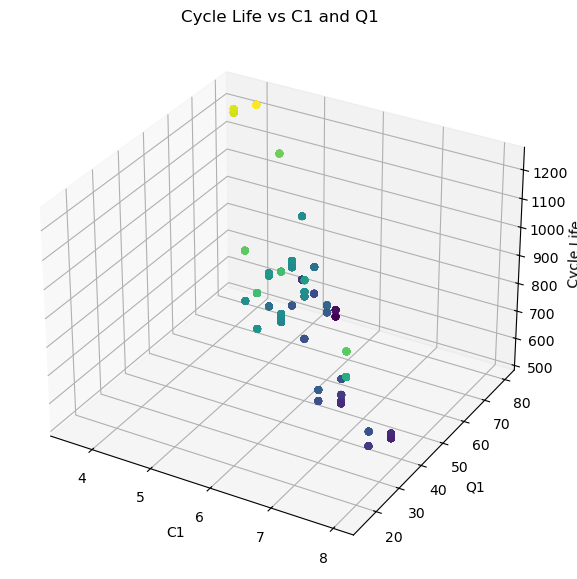

In [18]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Example DataFrame: Batch1
ax.scatter(Batch1['C1'], Batch1['Q1'], Batch1['cycle_life'], c=Batch1['cycle_life'], cmap='viridis')

ax.set_xlabel('C1')
ax.set_ylabel('Q1')
ax.set_zlabel('Cycle Life')
ax.set_title('Cycle Life vs C1 and Q1')

plt.show()


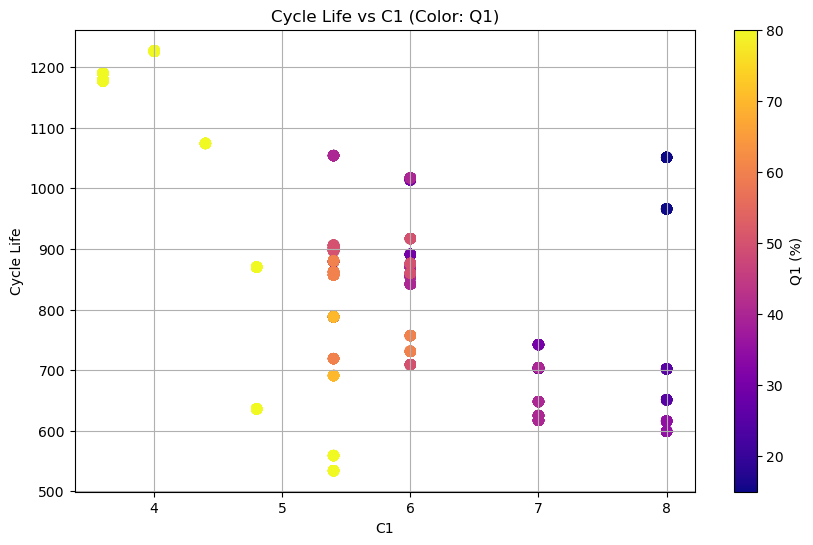

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
scatter = plt.scatter(Batch1['C1'], Batch1['cycle_life'], c=Batch1['Q1'], cmap='plasma', s=50)
plt.xlabel('C1')
plt.ylabel('Cycle Life')
plt.title('Cycle Life vs C1 (Color: Q1)')
plt.colorbar(scatter, label='Q1 (%)')
plt.grid(True)
plt.show()


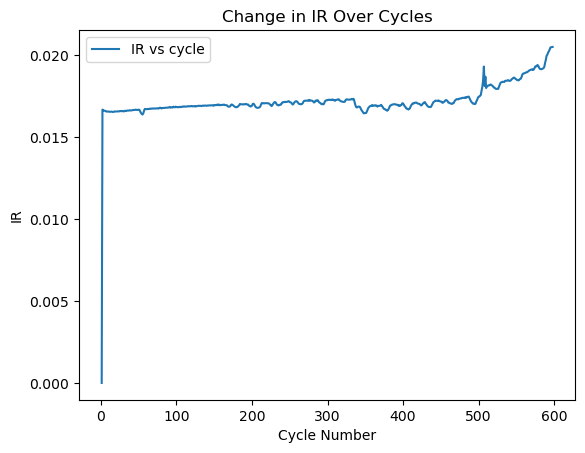

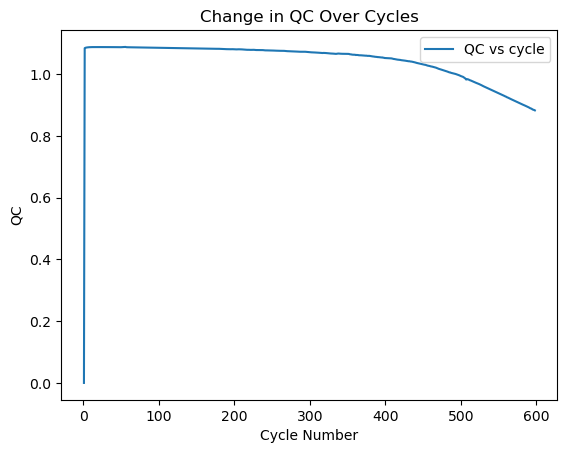

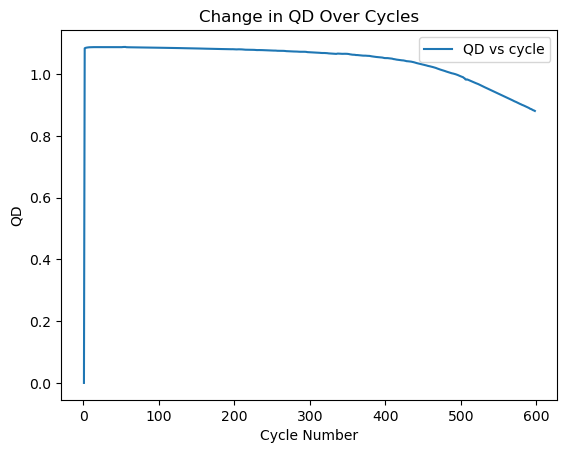

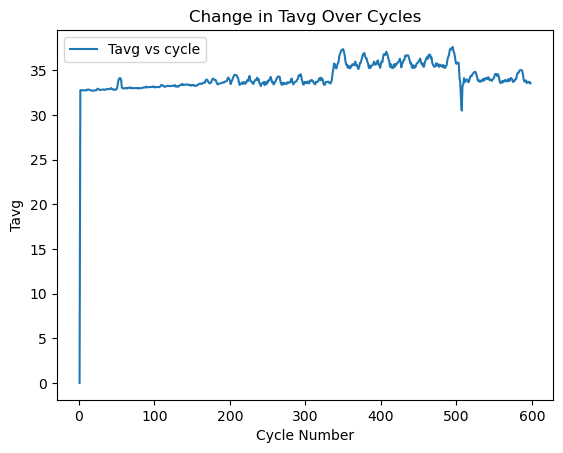

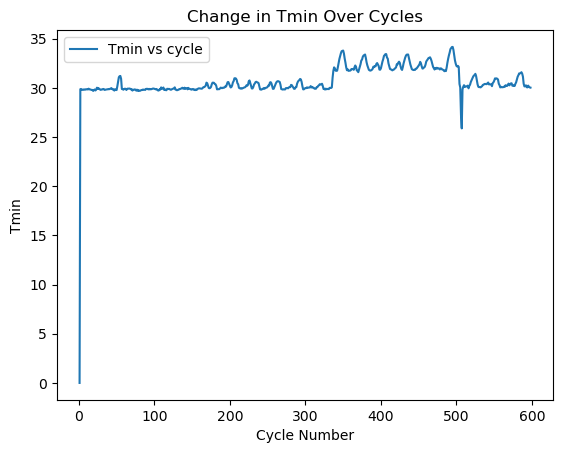

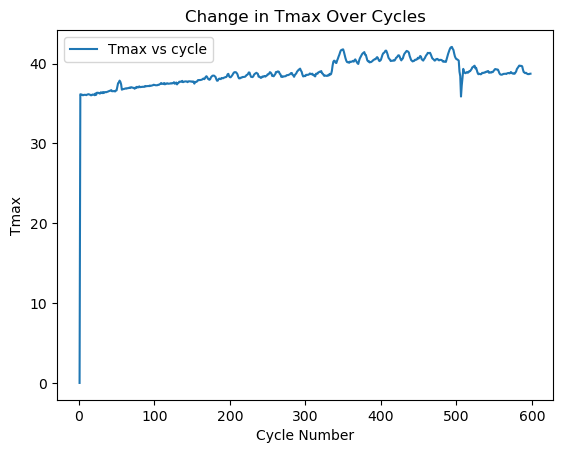

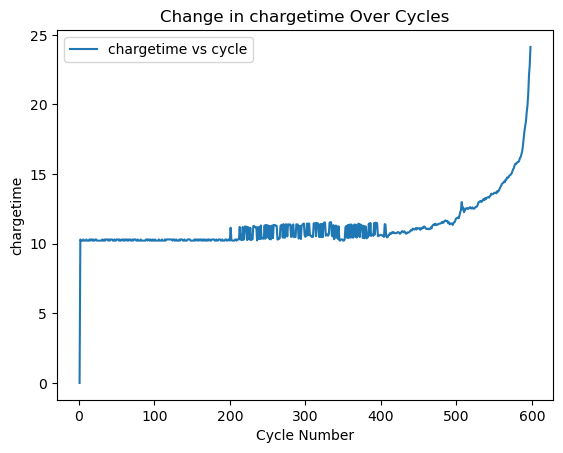

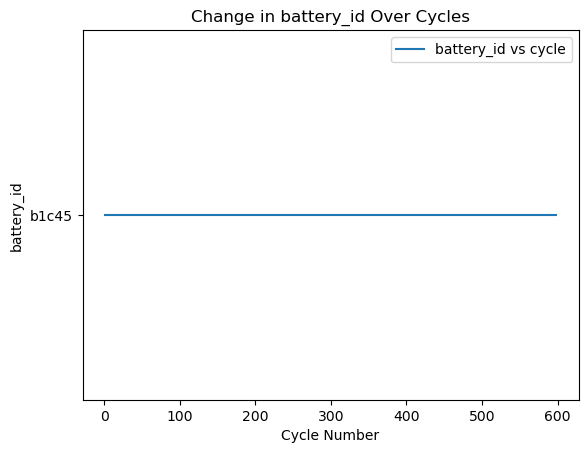

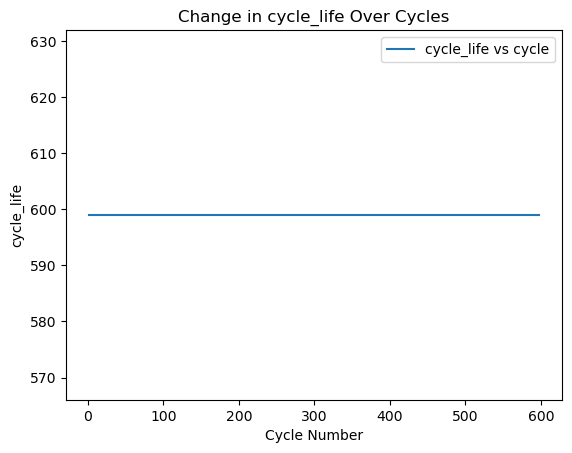

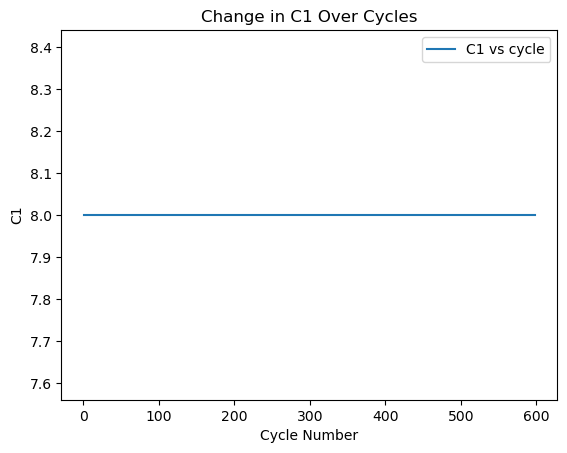

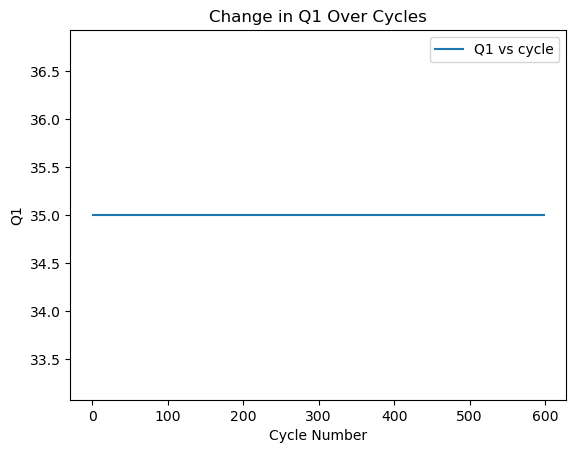

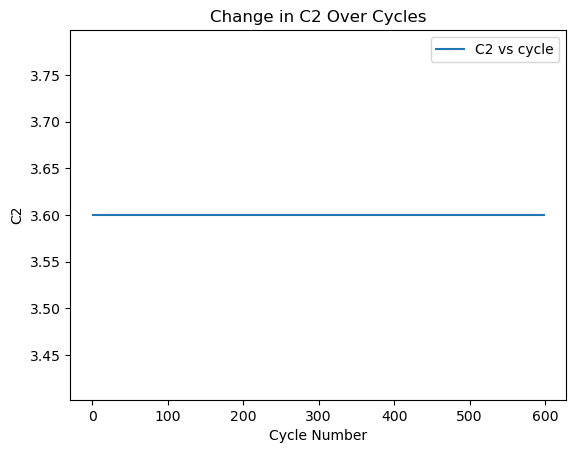

In [20]:
for i in df:
    if i!='cycle':
        plt.figure()
        plt.plot(df['cycle'],df[f"{i}"], label=f"{i} vs cycle")
        plt.xlabel('Cycle Number')
        plt.ylabel(f"{i}")
        plt.title(f"Change in {i} Over Cycles")
        plt.legend()
        plt.show()

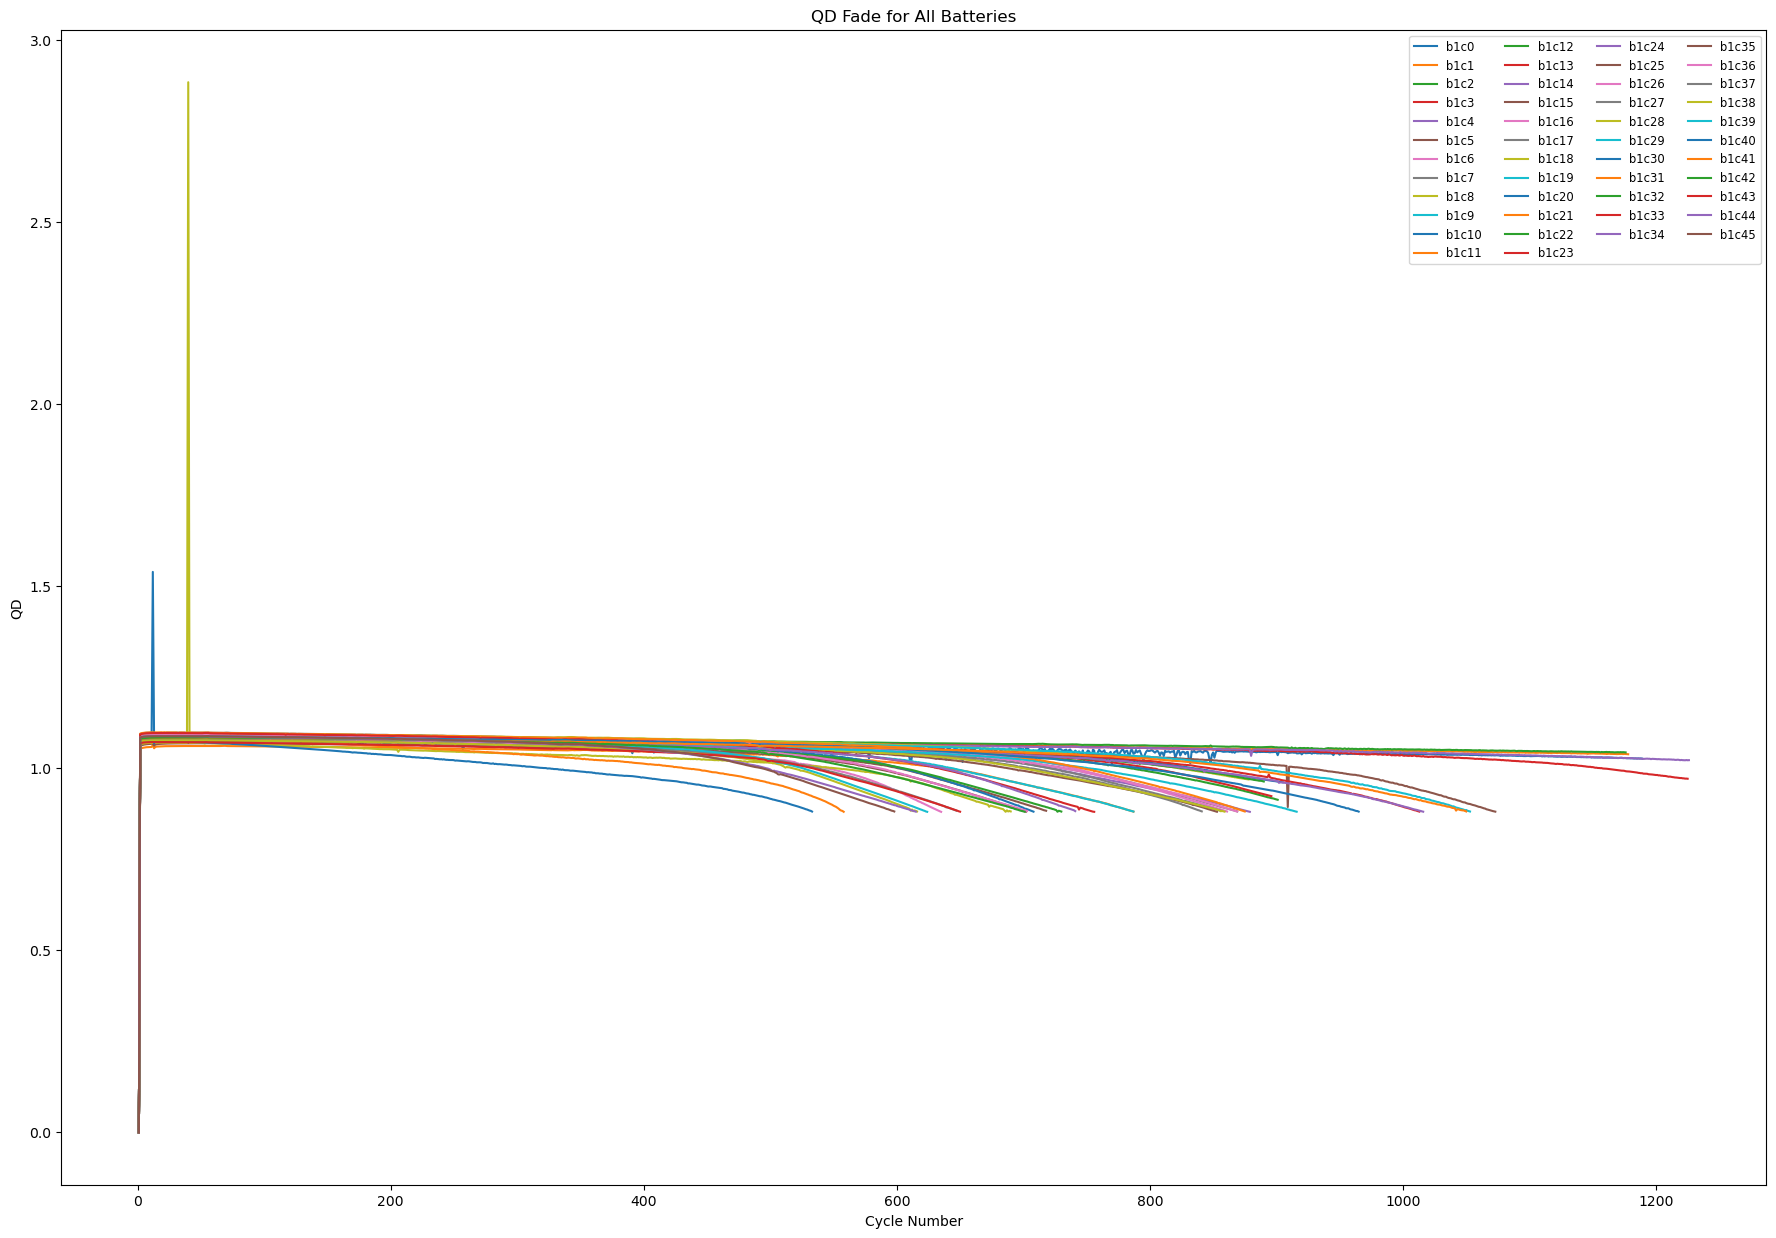

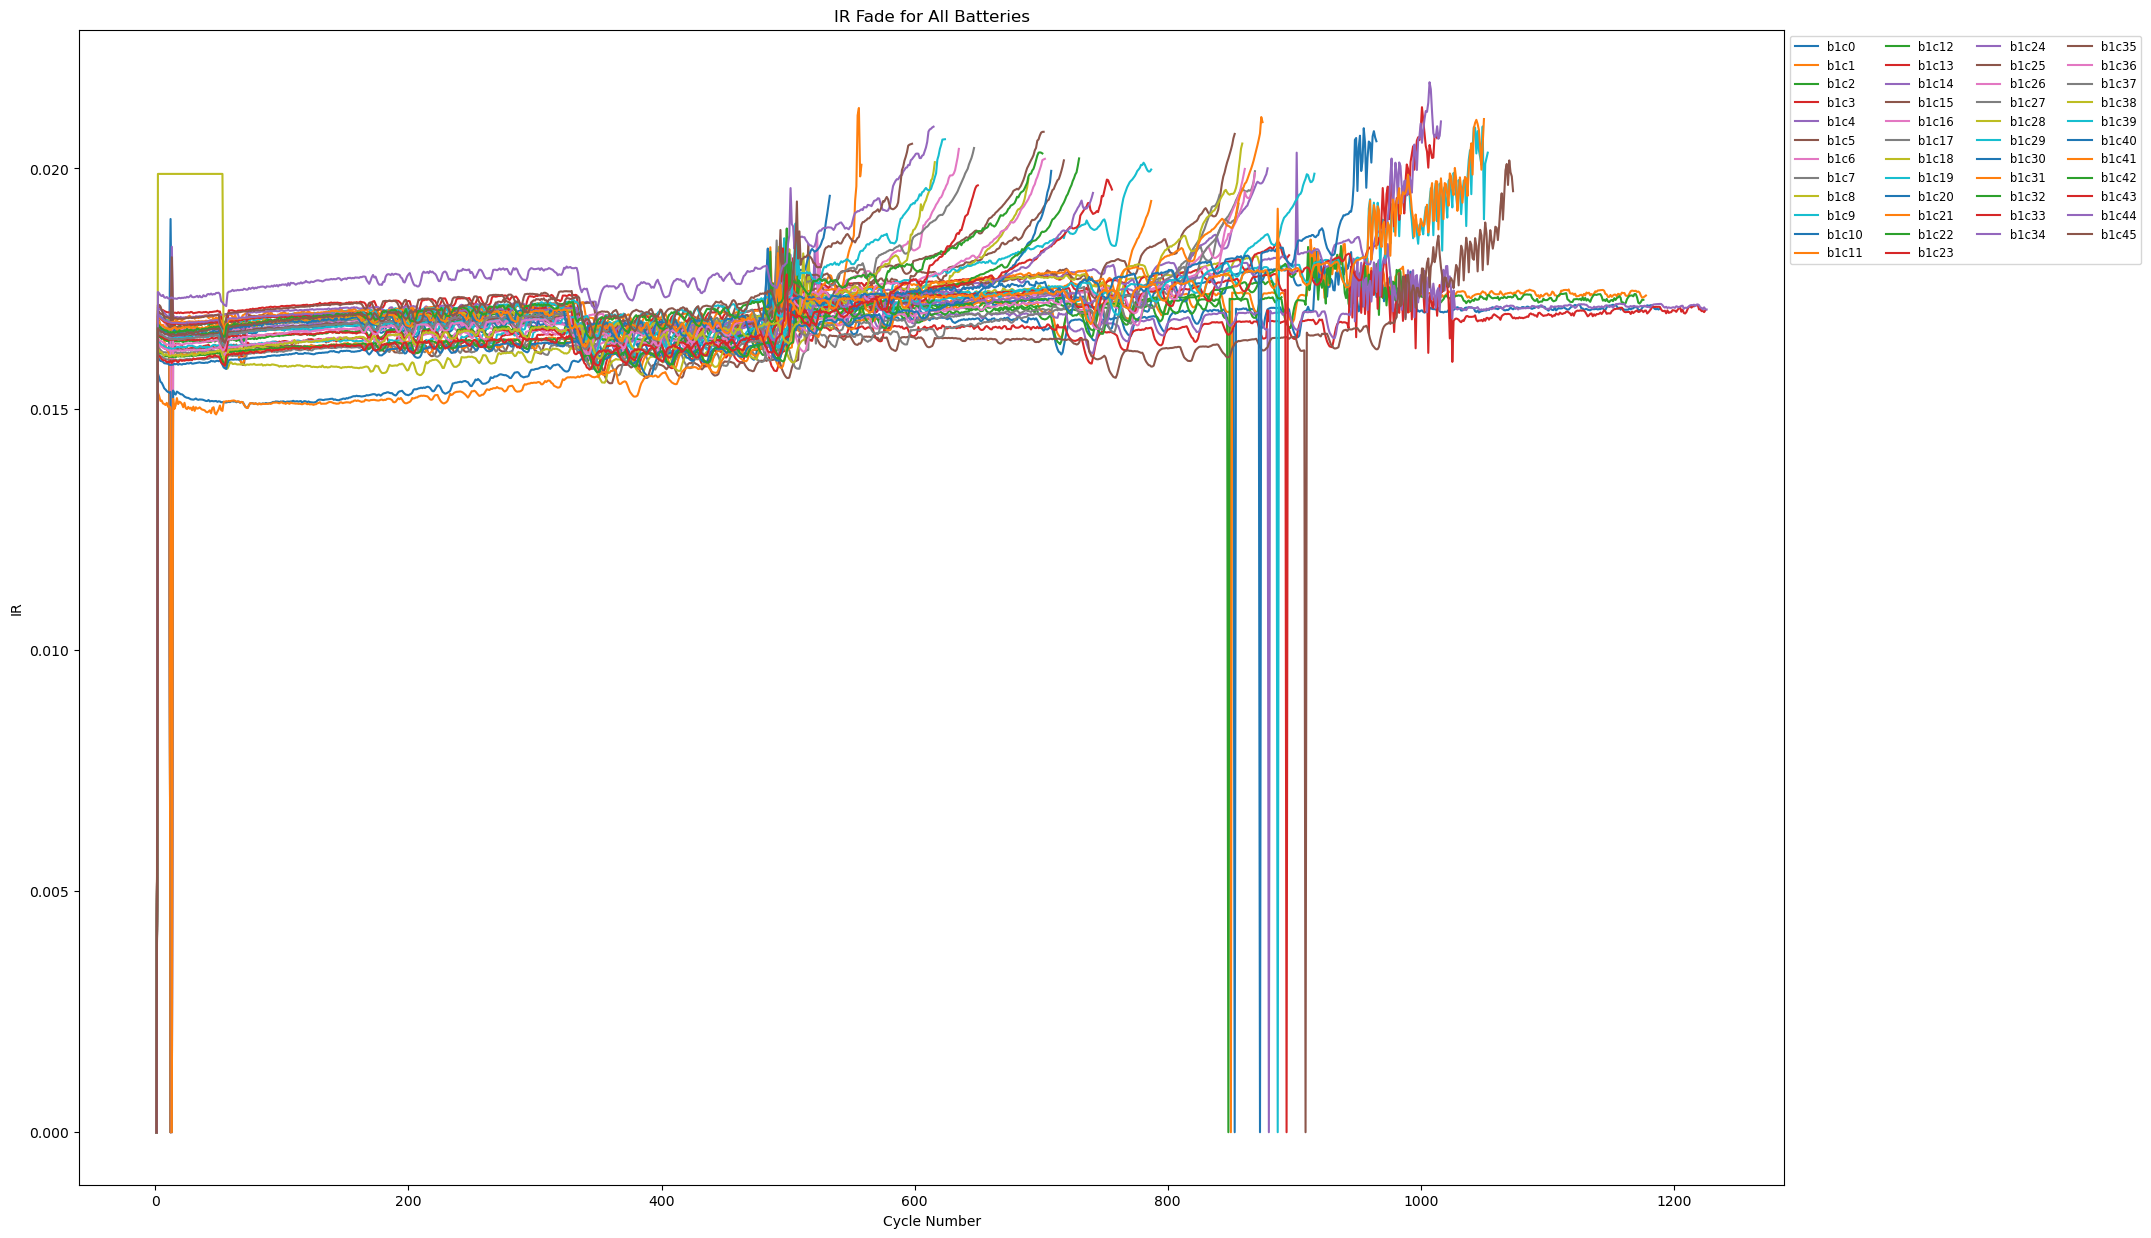

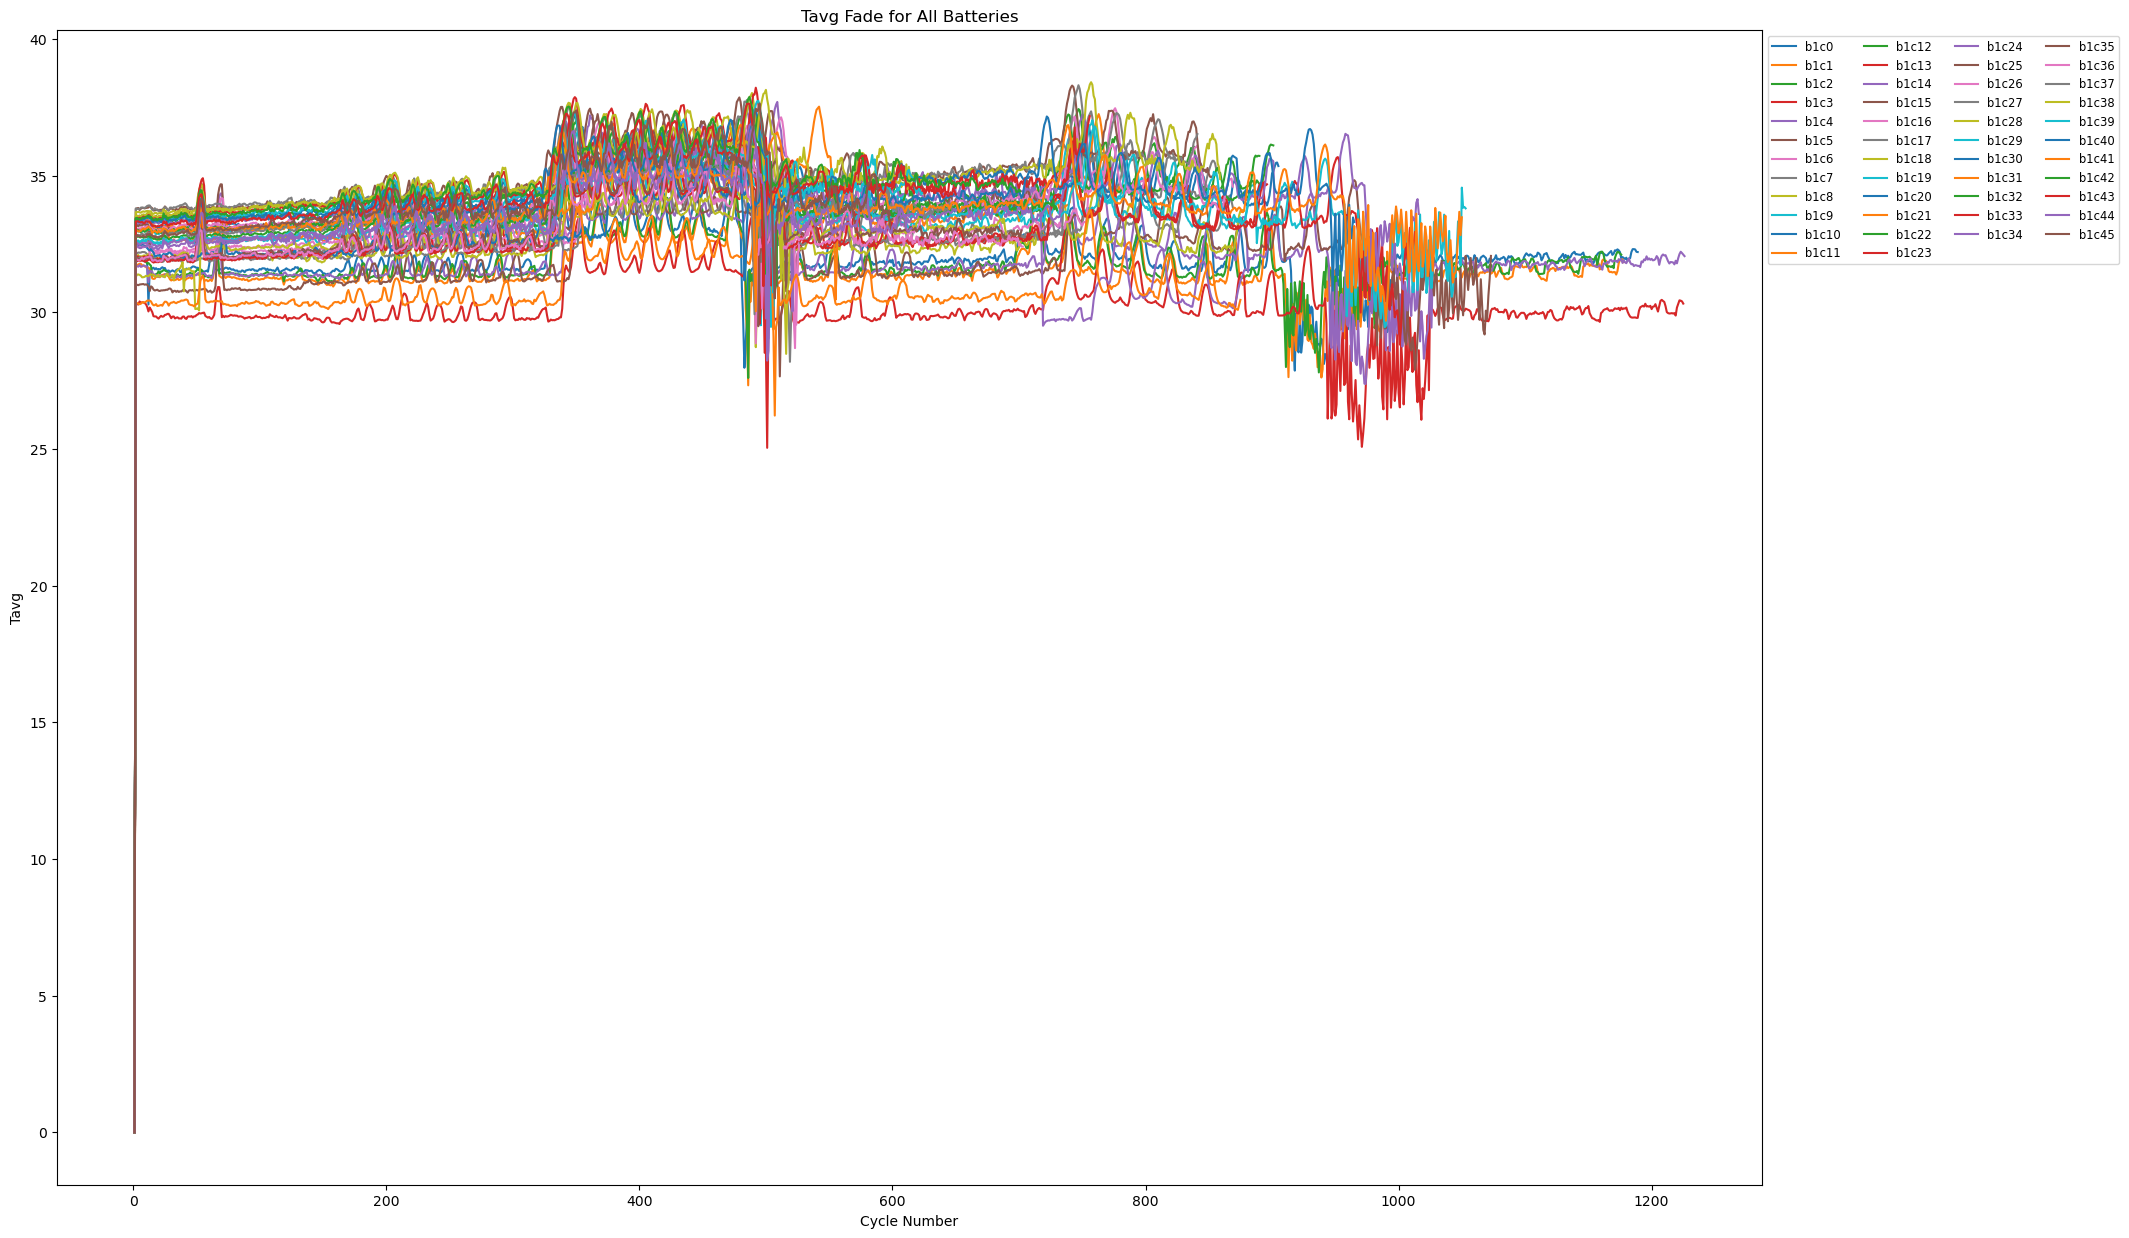

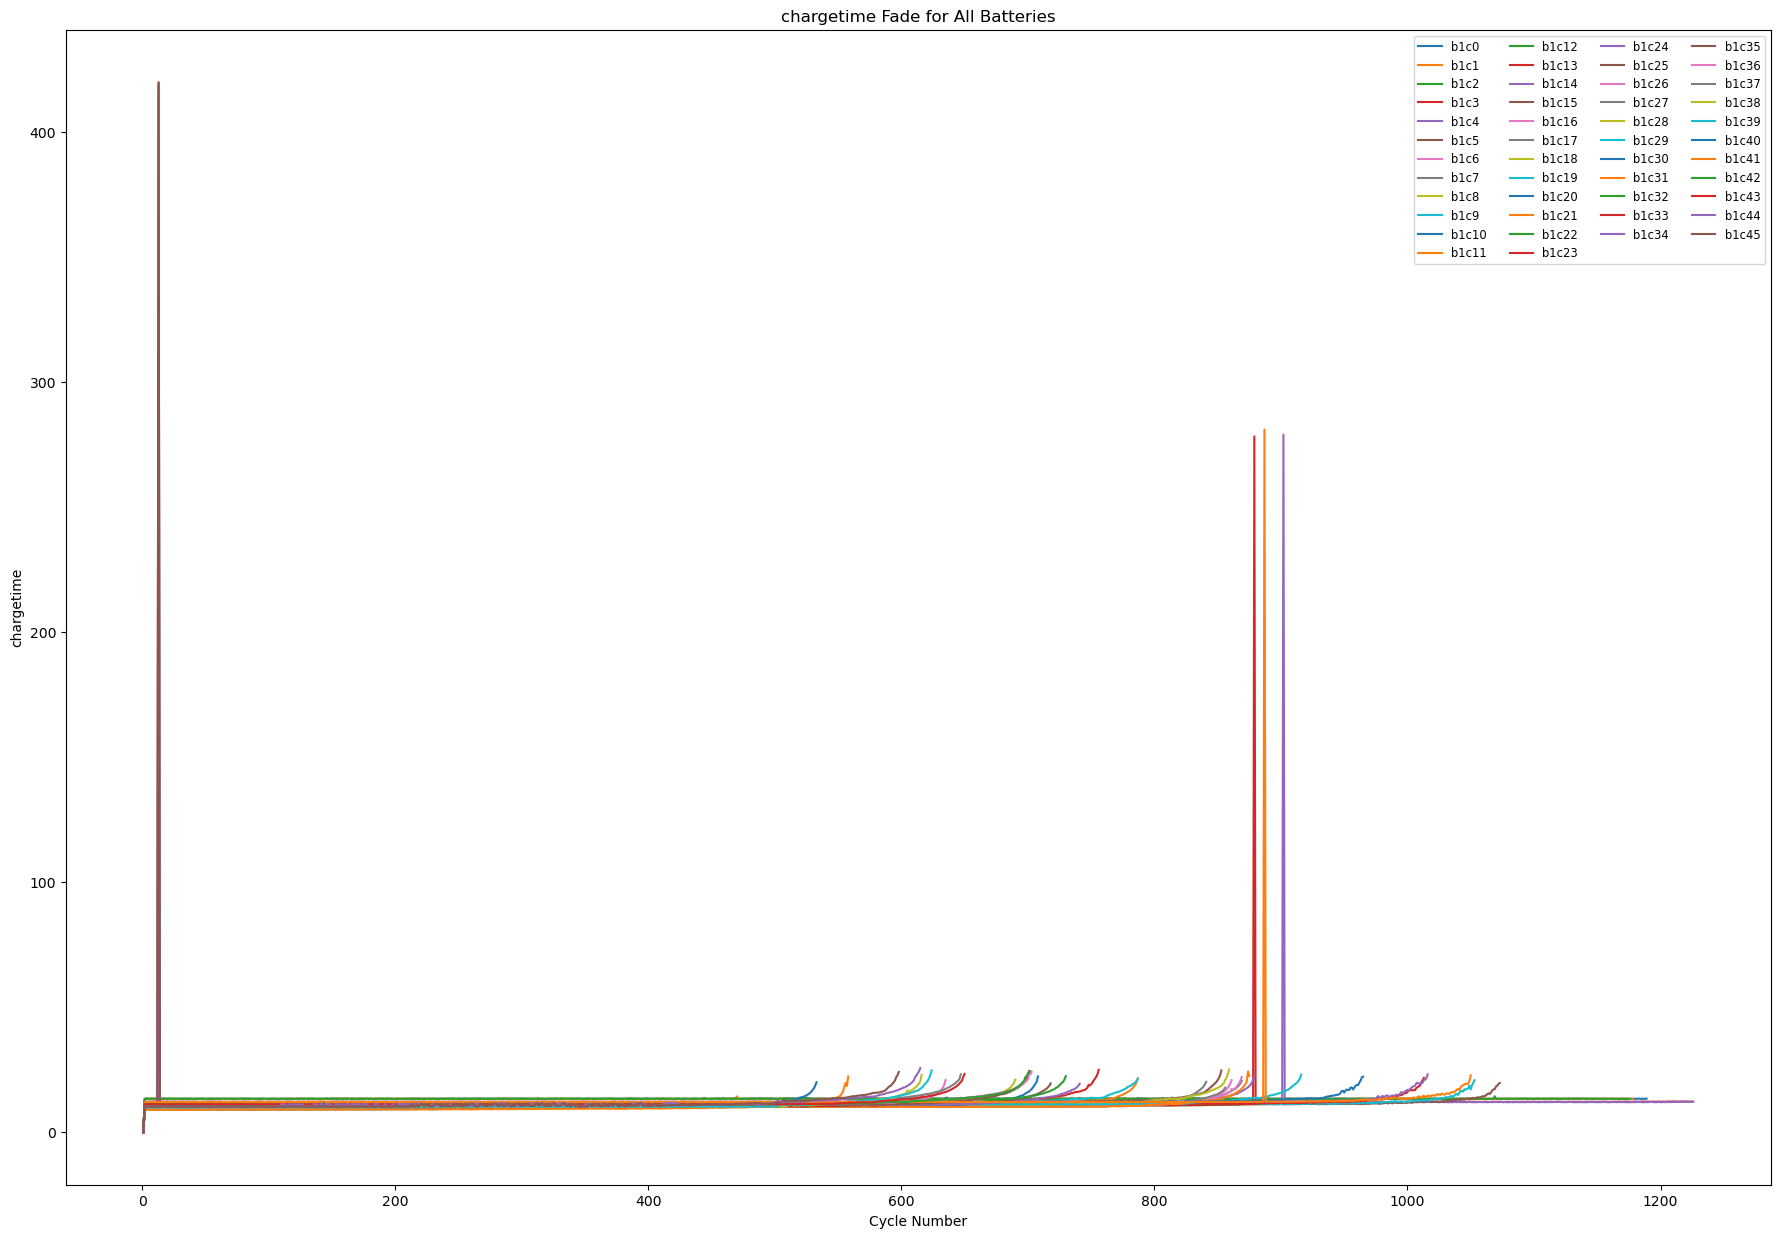

In [21]:
import matplotlib.pyplot as plt

def plot_feature_vs_cycles(bat_dict, feature='QD'):
    """
    Plot a specified feature against cycles for all batteries in the bat_dict.

    Args:
        bat_dict (dict): Battery data with 'summary'
        feature (str): The key to plot (like 'QD', 'QC', 'IR', 'Tavg', etc.)
    """
    plt.figure(figsize=(22, 15)) 
    for key, cell in bat_dict.items():
        if feature in cell['summary']:
            values = cell['summary'][feature]
            cycles = cell['summary']['cycle']

            plt.plot(cycles, values, label=key)

    plt.xlabel('Cycle Number')
    plt.ylabel(f'{feature}')
    plt.title(f'{feature} Fade for All Batteries')
    plt.legend(ncol=4, bbox_to_anchor=(1, 1), fontsize='small')
    plt.show()

# Example usage:
plot_feature_vs_cycles(bat_dict, feature='QD')
plot_feature_vs_cycles(bat_dict, feature='IR')
plot_feature_vs_cycles(bat_dict, feature='Tavg')
plot_feature_vs_cycles(bat_dict, feature='chargetime')


In [22]:
matFilename2 = '2017-06-30_batchdata_updated_struct_errorcorrect.mat'
f = h5py.File(matFilename2)
batch = f['batch']

In [23]:
num_cells = batch['summary'].shape[0]
bat_dict2= {}

for i in range(num_cells):
    cl = f[batch['cycle_life'][i, 0]][()].item()
    policy = f[batch['policy_readable'][i, 0]][()].tobytes()[::2].decode()
    summary_IR = np.hstack([f[batch['summary'][i, 0]]['IR'][0,:][()].flatten()])
    summary_QC = np.hstack([f[batch['summary'][i, 0]]['QCharge'][0,:][()].flatten()])
    summary_QD = np.hstack([f[batch['summary'][i, 0]]['QDischarge'][0,:][()].flatten()])
    summary_TA = np.hstack([f[batch['summary'][i, 0]]['Tavg'][0,:][()].flatten()])
    summary_TM = np.hstack([f[batch['summary'][i, 0]]['Tmin'][0,:][()].flatten()])
    summary_TX = np.hstack([f[batch['summary'][i, 0]]['Tmax'][0,:][()].flatten()])
    summary_CT = np.hstack([f[batch['summary'][i, 0]]['chargetime'][0,:][()].flatten()])
    summary_CY = np.hstack([f[batch['summary'][i, 0]]['cycle'][0,:][()].flatten()])
    summary = {
        'IR': summary_IR, 'QC': summary_QC, 'QD': summary_QD, 
        'Tavg': summary_TA, 'Tmin': summary_TM, 'Tmax': summary_TX, 
        'chargetime': summary_CT, 'cycle': summary_CY
    }
    cycles = f[batch['cycles'][i, 0]]
    cycle_dict = {}
    for j in range(cycles['I'].shape[0]):
        I = f[cycles['I'][j, 0]][()].flatten()
        Qc = f[cycles['Qc'][j, 0]][()].flatten()
        Qd = f[cycles['Qd'][j, 0]][()].flatten()
        Qdlin = f[cycles['Qdlin'][j, 0]][()].flatten()
        T = f[cycles['T'][j, 0]][()].flatten()
        Tdlin = f[cycles['Tdlin'][j, 0]][()].flatten()
        V = f[cycles['V'][j, 0]][()].flatten()
        dQdV = f[cycles['discharge_dQdV'][j, 0]][()].flatten()
        t = f[cycles['t'][j, 0]][()].flatten()
        cd = {
            'I': I, 'Qc': Qc, 'Qd': Qd, 'Qdlin': Qdlin, 
            'T': T, 'Tdlin': Tdlin, 'V': V, 'dQdV': dQdV, 't': t
        }
        cycle_dict[str(j)] = cd
    
    cell_dict = {
        'cycle_life': cl,
        'charge_policy': policy,
        'summary': summary,
        'cycles': cycle_dict
    }
    key = 'b2c' + str(i)
    bat_dict2[key] = cell_dict

In [24]:
bat_dict2.keys()

dict_keys(['b2c0', 'b2c1', 'b2c2', 'b2c3', 'b2c4', 'b2c5', 'b2c6', 'b2c7', 'b2c8', 'b2c9', 'b2c10', 'b2c11', 'b2c12', 'b2c13', 'b2c14', 'b2c15', 'b2c16', 'b2c17', 'b2c18', 'b2c19', 'b2c20', 'b2c21', 'b2c22', 'b2c23', 'b2c24', 'b2c25', 'b2c26', 'b2c27', 'b2c28', 'b2c29', 'b2c30', 'b2c31', 'b2c32', 'b2c33', 'b2c34', 'b2c35', 'b2c36', 'b2c37', 'b2c38', 'b2c39', 'b2c40', 'b2c41', 'b2c42', 'b2c43', 'b2c44', 'b2c45', 'b2c46', 'b2c47'])

In [25]:
import pandas as pd

frames = []

for key, cell in bat_dict2.items():
    df = pd.DataFrame(cell['summary'])
    df['cycle_life'] = cell['cycle_life']
    df['battery_id'] = key  # adding a new column with the battery's ID
    frames.append(df)

# Combine all into a single DataFrame
combined_df2 = pd.concat(frames, ignore_index=True)

print("Preview of combined DataFrame1:")
combined_df2

Preview of combined DataFrame1:


,IR,QC,QD,Tavg,Tmin,Tmax,chargetime,cycle,cycle_life,battery_id
0,0.017542,1.067561,1.068057,30.363545,28.999689,31.487127,10.332668,1.0,300.0,b2c0
1,0.017505,1.069810,1.070054,29.160560,26.734909,31.661930,10.180050,2.0,300.0,b2c0
2,0.017571,1.071287,1.071910,29.711384,28.086988,31.111683,10.308322,3.0,300.0,b2c0
3,0.017263,1.072626,1.072965,30.235232,28.464998,31.539034,10.276183,4.0,300.0,b2c0
4,0.017489,1.071483,1.071910,29.481769,27.695206,31.414228,10.263642,5.0,300.0,b2c0
...,...,...,...,...,...,...,...,...,...,...
24915,0.020284,0.836581,0.834485,33.351623,29.902174,38.214260,20.000000,741.0,713.0,b2c47
24916,0.020283,0.834719,0.832141,33.224035,29.923616,38.253880,20.000000,742.0,713.0,b2c47
24917,0.020371,0.832569,0.830499,33.282337,29.813374,38.336826,20.000000,743.0,713.0,b2c47
24918,0.020406,0.830548,0.828347,33.373176,29.784494,38.279568,20.000000,744.0,713.0,b2c47


In [26]:
import pandas as pd

frames = []

for key, cell in bat_dict2.items():
    df = pd.DataFrame(cell['summary'])
    df['cycle_life'] = cell['cycle_life']
    df['battery_id'] = key

    # Keep only the first 50 cycles for each battery
    df = df[df['cycle'] <= 50]

    frames.append(df)

# Combine all into a single DataFrame
Batch2 = pd.concat(frames, ignore_index=True)

print("Preview of first-50-cycles-only DataFrame:")
Batch2


Preview of first-50-cycles-only DataFrame:


,IR,QC,QD,Tavg,Tmin,Tmax,chargetime,cycle,cycle_life,battery_id
0,0.017542,1.067561,1.068057,30.363545,28.999689,31.487127,10.332668,1.0,300.0,b2c0
1,0.017505,1.069810,1.070054,29.160560,26.734909,31.661930,10.180050,2.0,300.0,b2c0
2,0.017571,1.071287,1.071910,29.711384,28.086988,31.111683,10.308322,3.0,300.0,b2c0
3,0.017263,1.072626,1.072965,30.235232,28.464998,31.539034,10.276183,4.0,300.0,b2c0
4,0.017489,1.071483,1.071910,29.481769,27.695206,31.414228,10.263642,5.0,300.0,b2c0
...,...,...,...,...,...,...,...,...,...,...
2395,0.017171,1.049489,1.049833,32.497725,29.385515,36.459629,10.179140,46.0,713.0,b2c47
2396,0.017159,1.049492,1.049915,32.435424,29.585482,36.574768,10.179088,47.0,713.0,b2c47
2397,0.017161,1.049419,1.049806,32.397096,29.739912,36.586670,10.179405,48.0,713.0,b2c47
2398,0.017146,1.049345,1.049750,32.311683,29.463625,36.295872,10.096282,49.0,713.0,b2c47


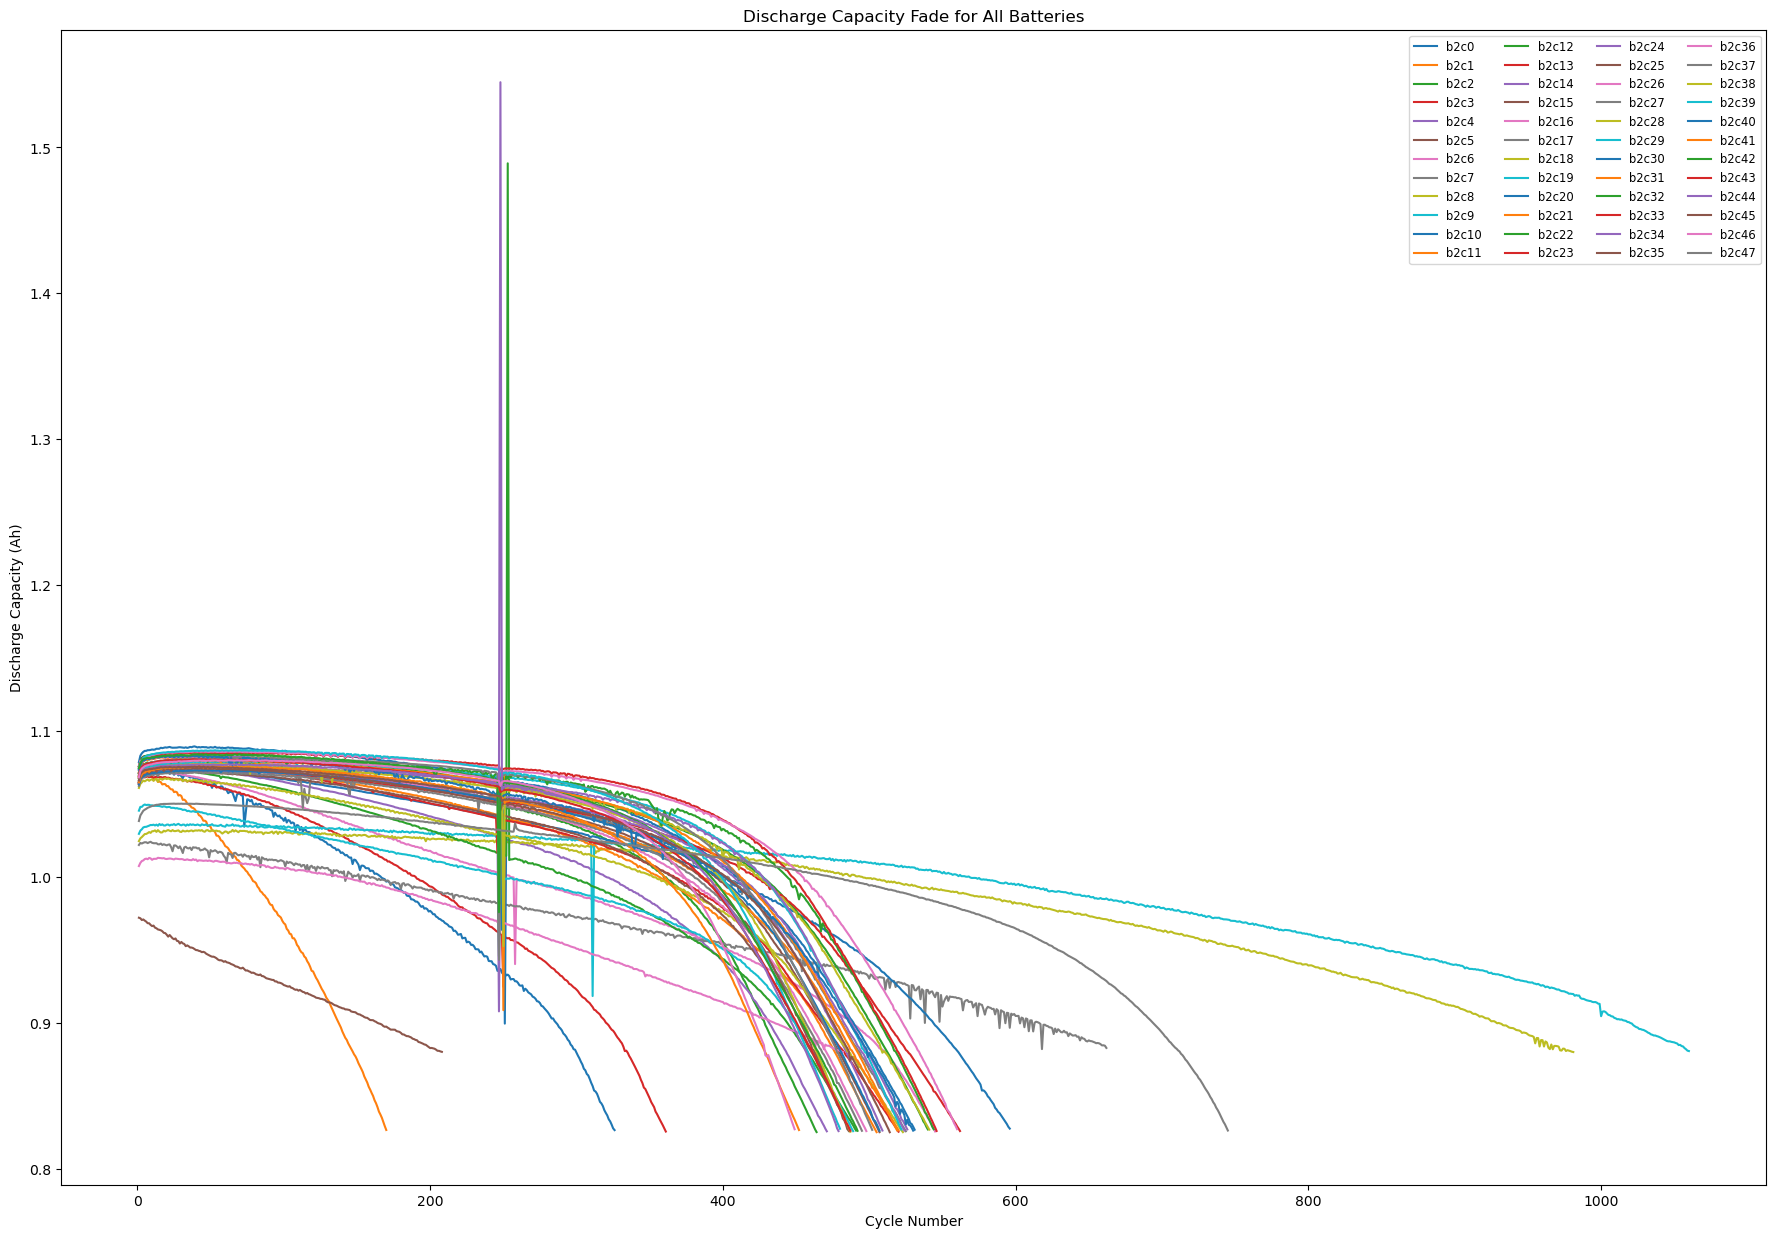

In [27]:

plt.figure(figsize=(22, 15)) 
for key, cell in bat_dict2.items():
    QD = cell['summary']['QD']
    cycles = cell['summary']['cycle']

    plt.plot(cycles, QD, label=key)

plt.xlabel('Cycle Number')
plt.ylabel('Discharge Capacity (Ah)')
plt.title('Discharge Capacity Fade for All Batteries')
plt.legend(ncol=4, bbox_to_anchor=(1, 1), fontsize='small')
plt.show()

In [28]:
matFilename2 = '2018-04-12_batchdata_updated_struct_errorcorrect.mat'
f = h5py.File(matFilename2)
batch = f['batch']

In [29]:
num_cells = batch['summary'].shape[0]
bat_dict3= {}

for i in range(num_cells):
    cl = f[batch['cycle_life'][i, 0]][()].item()
    policy = f[batch['policy_readable'][i, 0]][()].tobytes()[::2].decode()
    summary_IR = np.hstack([f[batch['summary'][i, 0]]['IR'][0,:][()].flatten()])
    summary_QC = np.hstack([f[batch['summary'][i, 0]]['QCharge'][0,:][()].flatten()])
    summary_QD = np.hstack([f[batch['summary'][i, 0]]['QDischarge'][0,:][()].flatten()])
    summary_TA = np.hstack([f[batch['summary'][i, 0]]['Tavg'][0,:][()].flatten()])
    summary_TM = np.hstack([f[batch['summary'][i, 0]]['Tmin'][0,:][()].flatten()])
    summary_TX = np.hstack([f[batch['summary'][i, 0]]['Tmax'][0,:][()].flatten()])
    summary_CT = np.hstack([f[batch['summary'][i, 0]]['chargetime'][0,:][()].flatten()])
    summary_CY = np.hstack([f[batch['summary'][i, 0]]['cycle'][0,:][()].flatten()])
    summary = {
        'IR': summary_IR, 'QC': summary_QC, 'QD': summary_QD, 
        'Tavg': summary_TA, 'Tmin': summary_TM, 'Tmax': summary_TX, 
        'chargetime': summary_CT, 'cycle': summary_CY
    }
    cycles = f[batch['cycles'][i, 0]]
    cycle_dict = {}
    for j in range(cycles['I'].shape[0]):
        I = f[cycles['I'][j, 0]][()].flatten()
        Qc = f[cycles['Qc'][j, 0]][()].flatten()
        Qd = f[cycles['Qd'][j, 0]][()].flatten()
        Qdlin = f[cycles['Qdlin'][j, 0]][()].flatten()
        T = f[cycles['T'][j, 0]][()].flatten()
        Tdlin = f[cycles['Tdlin'][j, 0]][()].flatten()
        V = f[cycles['V'][j, 0]][()].flatten()
        dQdV = f[cycles['discharge_dQdV'][j, 0]][()].flatten()
        t = f[cycles['t'][j, 0]][()].flatten()
        cd = {
            'I': I, 'Qc': Qc, 'Qd': Qd, 'Qdlin': Qdlin, 
            'T': T, 'Tdlin': Tdlin, 'V': V, 'dQdV': dQdV, 't': t
        }
        cycle_dict[str(j)] = cd
    
    cell_dict = {
        'cycle_life': cl,
        'charge_policy': policy,
        'summary': summary,
        'cycles': cycle_dict
    }
    key = 'b3c' + str(i)
    bat_dict3[key] = cell_dict

In [30]:
bat_dict3.keys()

dict_keys(['b3c0', 'b3c1', 'b3c2', 'b3c3', 'b3c4', 'b3c5', 'b3c6', 'b3c7', 'b3c8', 'b3c9', 'b3c10', 'b3c11', 'b3c12', 'b3c13', 'b3c14', 'b3c15', 'b3c16', 'b3c17', 'b3c18', 'b3c19', 'b3c20', 'b3c21', 'b3c22', 'b3c23', 'b3c24', 'b3c25', 'b3c26', 'b3c27', 'b3c28', 'b3c29', 'b3c30', 'b3c31', 'b3c32', 'b3c33', 'b3c34', 'b3c35', 'b3c36', 'b3c37', 'b3c38', 'b3c39', 'b3c40', 'b3c41', 'b3c42', 'b3c43', 'b3c44', 'b3c45'])

In [31]:
import pandas as pd

frames = []

for key, cell in bat_dict3.items():
    df = pd.DataFrame(cell['summary'])
    df['cycle_life'] = cell['cycle_life']
    df['battery_id'] = key  # adding a new column with the battery's ID
    frames.append(df)

# Combine all into a single DataFrame
combined_df3 = pd.concat(frames, ignore_index=True)

print("Preview of combined DataFrame1:")
combined_df3

Preview of combined DataFrame1:


,IR,QC,QD,Tavg,Tmin,Tmax,chargetime,cycle,cycle_life,battery_id
0,0.015435,1.066090,1.066573,32.149495,30.830272,33.433834,10.043408,1.0,1009.0,b3c0
1,0.015399,1.066964,1.067455,32.106606,30.779943,33.403964,10.043255,2.0,1009.0,b3c0
2,0.015365,1.067611,1.068285,32.088511,30.824746,33.325268,10.042333,3.0,1009.0,b3c0
3,0.015326,1.068164,1.068708,32.086306,30.804544,33.304202,10.052677,4.0,1009.0,b3c0
4,0.015309,1.068695,1.069094,32.041147,30.791834,33.257191,10.042382,5.0,1009.0,b3c0
...,...,...,...,...,...,...,...,...,...,...
51002,0.017538,0.881796,0.881539,32.532753,30.328932,34.571934,15.404138,1796.0,1801.0,b3c45
51003,0.017294,0.881874,0.881441,32.679857,29.591684,35.492989,15.497987,1797.0,1801.0,b3c45
51004,0.017605,0.881364,0.880883,32.217071,31.470758,33.999550,16.357937,1798.0,1801.0,b3c45
51005,0.017526,0.881120,0.880757,33.035630,29.526152,35.779078,16.046140,1799.0,1801.0,b3c45


In [32]:
import pandas as pd

frames = []

for key, cell in bat_dict3.items():
    df = pd.DataFrame(cell['summary'])
    df['cycle_life'] = cell['cycle_life']
    df['battery_id'] = key

    # Keep only the first 50 cycles for each battery
    df = df[df['cycle'] <= 50]

    frames.append(df)

# Combine all into a single DataFrame
Batch3 = pd.concat(frames, ignore_index=True)

print("Preview of first-50-cycles-only DataFrame:")
Batch3


Preview of first-50-cycles-only DataFrame:


,IR,QC,QD,Tavg,Tmin,Tmax,chargetime,cycle,cycle_life,battery_id
0,0.015435,1.066090,1.066573,32.149495,30.830272,33.433834,10.043408,1.0,1009.0,b3c0
1,0.015399,1.066964,1.067455,32.106606,30.779943,33.403964,10.043255,2.0,1009.0,b3c0
2,0.015365,1.067611,1.068285,32.088511,30.824746,33.325268,10.042333,3.0,1009.0,b3c0
3,0.015326,1.068164,1.068708,32.086306,30.804544,33.304202,10.052677,4.0,1009.0,b3c0
4,0.015309,1.068695,1.069094,32.041147,30.791834,33.257191,10.042382,5.0,1009.0,b3c0
...,...,...,...,...,...,...,...,...,...,...
2295,0.015602,1.071451,1.071640,32.750094,30.891405,34.619160,11.036730,46.0,1801.0,b3c45
2296,0.015595,1.071707,1.071866,32.754391,30.828009,34.740250,11.036633,47.0,1801.0,b3c45
2297,0.015583,1.071824,1.072039,32.790772,30.861229,34.741764,11.036873,48.0,1801.0,b3c45
2298,0.015592,1.071991,1.072053,32.832211,30.947521,34.724735,11.037575,49.0,1801.0,b3c45


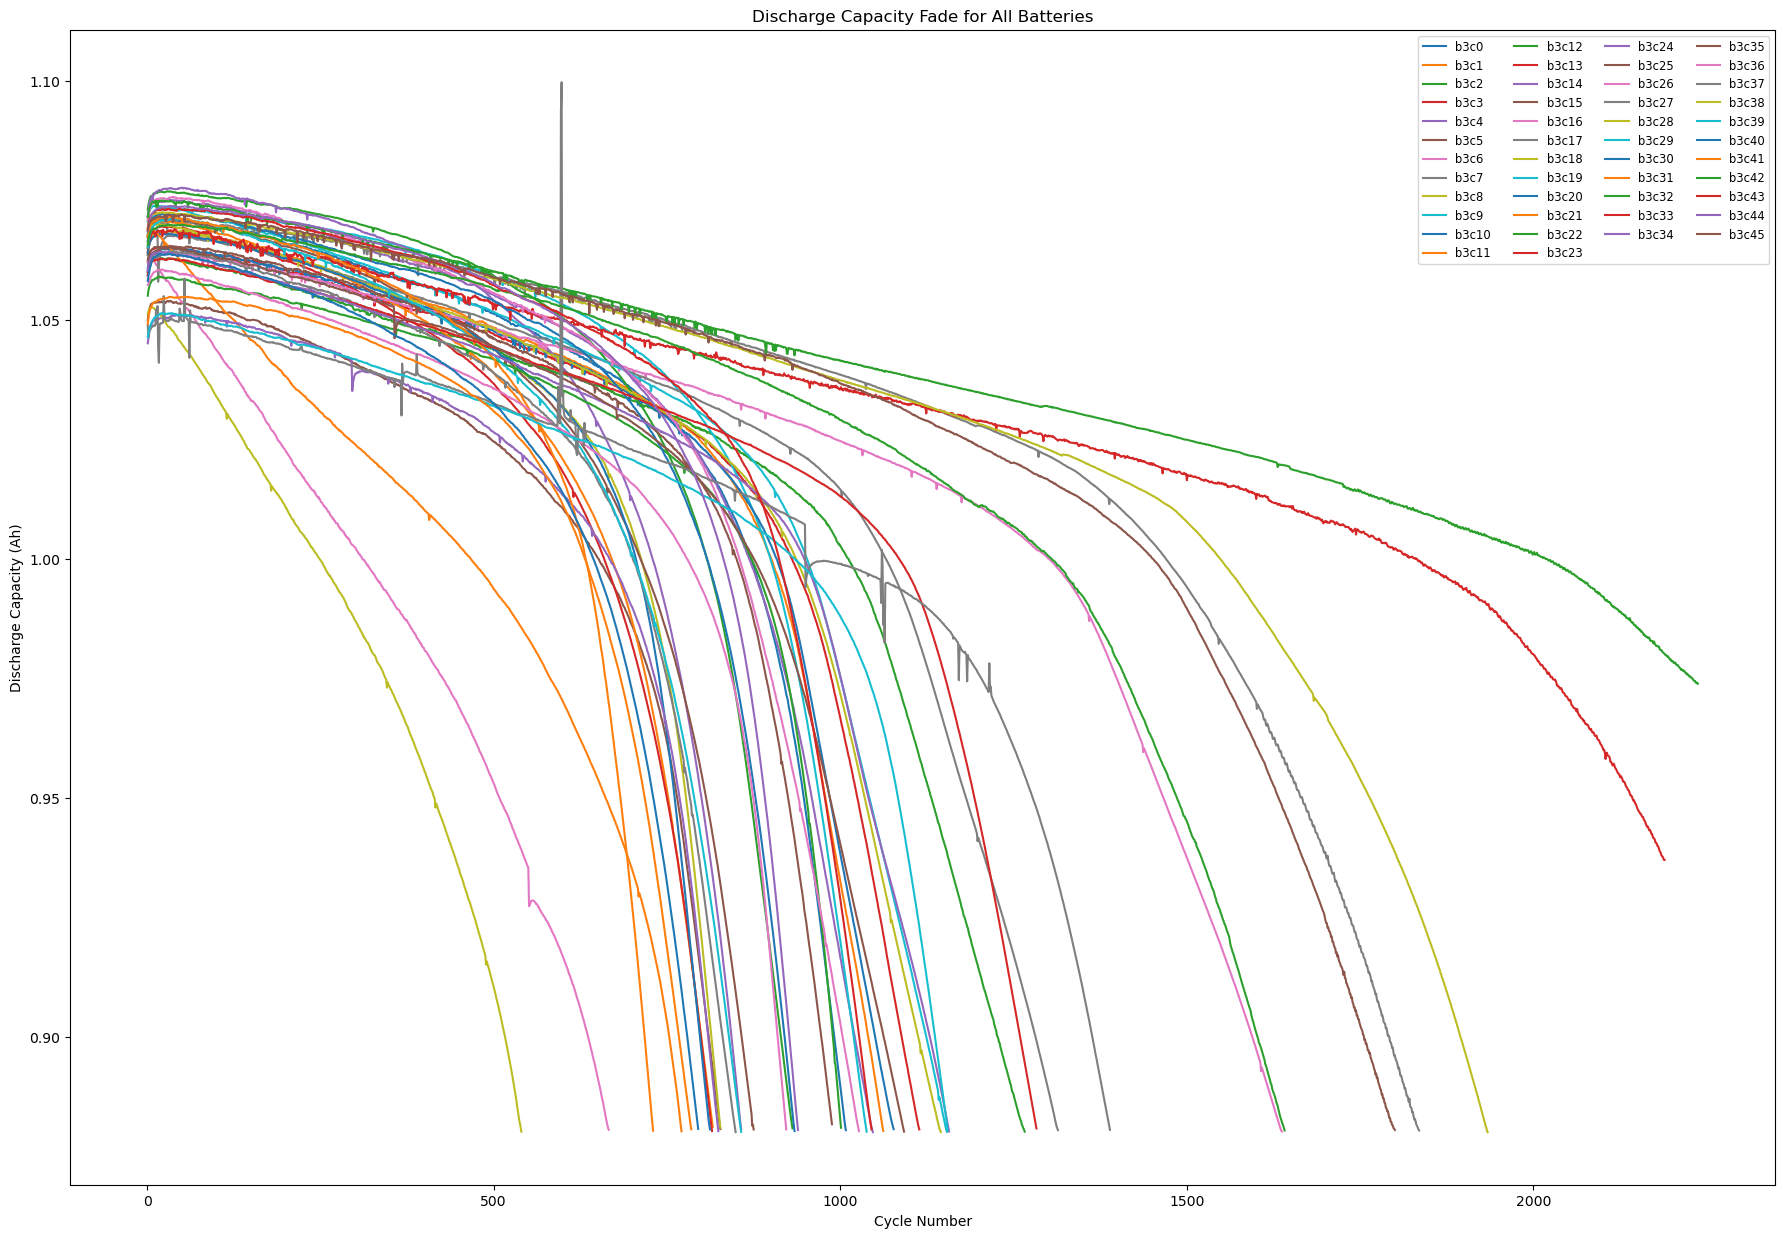

In [33]:
plt.figure(figsize=(22, 15)) 
for key, cell in bat_dict3.items():
    QD = cell['summary']['QD']
    cycles = cell['summary']['cycle']

    plt.plot(cycles, QD, label=key)

plt.xlabel('Cycle Number')
plt.ylabel('Discharge Capacity (Ah)')
plt.title('Discharge Capacity Fade for All Batteries')
plt.legend(ncol=4, bbox_to_anchor=(1, 1), fontsize='small')
plt.show()

In [34]:
# import pandas as pd

# # Combine all into a single DataFrame
# final_df = pd.concat([combined_df1, combined_df2, combined_df3], ignore_index=True)

# print("Final combined DataFrame:")


# print("Final shape :", final_df.shape)
# final_df

In [35]:
total_Batch= pd.concat([Batch1,Batch2,Batch3])
total_Batch

,IR,QC,QD,Tavg,Tmin,Tmax,chargetime,cycle,battery_id,cycle_life,C1,Q1,C2
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,b1c0,1190.0,3.6,80.0,3.6
1,0.016742,1.071042,1.070689,31.875011,29.566130,35.652016,13.341250,2.0,b1c0,1190.0,3.6,80.0,3.6
2,0.016724,1.071674,1.071900,31.931490,29.604385,35.692978,13.425777,3.0,b1c0,1190.0,3.6,80.0,3.6
3,0.016681,1.072304,1.072510,31.932603,29.744202,35.680588,13.425167,4.0,b1c0,1190.0,3.6,80.0,3.6
4,0.016662,1.072970,1.073174,31.959322,29.644709,35.728691,13.341442,5.0,b1c0,1190.0,3.6,80.0,3.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2295,0.015602,1.071451,1.071640,32.750094,30.891405,34.619160,11.036730,46.0,b3c45,1801.0,NaN,NaN,NaN
2296,0.015595,1.071707,1.071866,32.754391,30.828009,34.740250,11.036633,47.0,b3c45,1801.0,NaN,NaN,NaN
2297,0.015583,1.071824,1.072039,32.790772,30.861229,34.741764,11.036873,48.0,b3c45,1801.0,NaN,NaN,NaN
2298,0.015592,1.071991,1.072053,32.832211,30.947521,34.724735,11.037575,49.0,b3c45,1801.0,NaN,NaN,NaN


In [36]:
total_df = total_Batch.copy()
total_df

,IR,QC,QD,Tavg,Tmin,Tmax,chargetime,cycle,battery_id,cycle_life,C1,Q1,C2
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,b1c0,1190.0,3.6,80.0,3.6
1,0.016742,1.071042,1.070689,31.875011,29.566130,35.652016,13.341250,2.0,b1c0,1190.0,3.6,80.0,3.6
2,0.016724,1.071674,1.071900,31.931490,29.604385,35.692978,13.425777,3.0,b1c0,1190.0,3.6,80.0,3.6
3,0.016681,1.072304,1.072510,31.932603,29.744202,35.680588,13.425167,4.0,b1c0,1190.0,3.6,80.0,3.6
4,0.016662,1.072970,1.073174,31.959322,29.644709,35.728691,13.341442,5.0,b1c0,1190.0,3.6,80.0,3.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2295,0.015602,1.071451,1.071640,32.750094,30.891405,34.619160,11.036730,46.0,b3c45,1801.0,NaN,NaN,NaN
2296,0.015595,1.071707,1.071866,32.754391,30.828009,34.740250,11.036633,47.0,b3c45,1801.0,NaN,NaN,NaN
2297,0.015583,1.071824,1.072039,32.790772,30.861229,34.741764,11.036873,48.0,b3c45,1801.0,NaN,NaN,NaN
2298,0.015592,1.071991,1.072053,32.832211,30.947521,34.724735,11.037575,49.0,b3c45,1801.0,NaN,NaN,NaN


In [37]:
# from sklearn.model_selection import train_test_split

# # Split into 80% training and 20% testing
# train_df, test_df = train_test_split(total_df, test_size=0.2, random_state=42)

# print("Training set shape :", train_df.shape)
# print("Test set shape :", test_df.shape)

train_df=total_df.copy()

In [38]:
from sklearn.preprocessing import MinMaxScaler


# Define the features we want to scale
features = ['IR', 'QC', 'QD', 'Tavg', 'Tmin', 'Tmax', 'chargetime','cycle','cycle_life']

scaler = MinMaxScaler()

# Fit scaler on training data
train_df[features] = scaler.fit_transform(train_df[features])

print("Training set after scaling to [0,1]:")

# Fill missing values in your signals with column mean
train_df[features] = train_df[features].fillna(train_df[features].mean())  

print("Training set after filling NaNs with column mean:")




train_df

Training set after scaling to [0,1]:
Training set after filling NaNs with column mean:


,IR,QC,QD,Tavg,Tmin,Tmax,chargetime,cycle,battery_id,cycle_life,C1,Q1,C2
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,b1c0,0.583100,3.6,80.0,3.6
1,0.821774,0.361119,0.371241,0.852089,0.892542,0.867109,0.031774,0.020408,b1c0,0.583100,3.6,80.0,3.6
2,0.820888,0.361332,0.371661,0.853599,0.893696,0.868105,0.031976,0.040816,b1c0,0.583100,3.6,80.0,3.6
3,0.818774,0.361545,0.371872,0.853629,0.897917,0.867804,0.031974,0.061224,b1c0,0.583100,3.6,80.0,3.6
4,0.817823,0.361769,0.372102,0.854343,0.894914,0.868974,0.031775,0.081633,b1c0,0.583100,3.6,80.0,3.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2295,0.765791,0.361257,0.371570,0.875482,0.932549,0.841988,0.026286,0.918367,b3c45,0.925014,NaN,NaN,NaN
2296,0.765444,0.361344,0.371649,0.875597,0.930635,0.844933,0.026286,0.938776,b3c45,0.925014,NaN,NaN,NaN
2297,0.764891,0.361383,0.371709,0.876570,0.931638,0.844970,0.026286,0.959184,b3c45,0.925014,NaN,NaN,NaN
2298,0.765323,0.361439,0.371714,0.877677,0.934243,0.844556,0.026288,0.979592,b3c45,0.925014,NaN,NaN,NaN


In [39]:
import re

def encode_battery_id(bid):
    match = re.match(r"b(\d)c(\d+)", bid)
    if match:
        batch = int(match.group(1))
        cell = int(match.group(2))
        return batch * 100 + cell
    return -1  # in case of unexpected format

# Apply to training data
train_df['battery_id'] = train_df['battery_id'].apply(encode_battery_id)

train_df


,IR,QC,QD,Tavg,Tmin,Tmax,chargetime,cycle,battery_id,cycle_life,C1,Q1,C2
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100,0.583100,3.6,80.0,3.6
1,0.821774,0.361119,0.371241,0.852089,0.892542,0.867109,0.031774,0.020408,100,0.583100,3.6,80.0,3.6
2,0.820888,0.361332,0.371661,0.853599,0.893696,0.868105,0.031976,0.040816,100,0.583100,3.6,80.0,3.6
3,0.818774,0.361545,0.371872,0.853629,0.897917,0.867804,0.031974,0.061224,100,0.583100,3.6,80.0,3.6
4,0.817823,0.361769,0.372102,0.854343,0.894914,0.868974,0.031775,0.081633,100,0.583100,3.6,80.0,3.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2295,0.765791,0.361257,0.371570,0.875482,0.932549,0.841988,0.026286,0.918367,345,0.925014,NaN,NaN,NaN
2296,0.765444,0.361344,0.371649,0.875597,0.930635,0.844933,0.026286,0.938776,345,0.925014,NaN,NaN,NaN
2297,0.764891,0.361383,0.371709,0.876570,0.931638,0.844970,0.026286,0.959184,345,0.925014,NaN,NaN,NaN
2298,0.765323,0.361439,0.371714,0.877677,0.934243,0.844556,0.026288,0.979592,345,0.925014,NaN,NaN,NaN


In [61]:
# Assuming your DataFrame is named `df` or similar
train_df.to_csv("battery_life_first_50_cycles_ss.csv", index=False, sep=',')  # or sep=';' if Excel uses semicolons


In [41]:
import pandas as pd

train_df= pd.read_csv("battery_life_first_50_cycles.csv")


In [42]:
train_df_XGboost=train_df.copy()

In [43]:
battery_lengths = train_df.groupby('battery_id').size()
print("Battery lengths:\n", battery_lengths.sort_values())


Battery lengths:
 battery_id
100    50
101    50
102    50
103    50
104    50
       ..
341    50
342    50
343    50
344    50
345    50
Length: 140, dtype: int64


In [44]:
# Define signals (your 7 features after scaling and dropping IDs).
features = ['IR', 'QC', 'QD', 'Tavg', 'Tmin', 'Tmax', 'chargetime']

# Prepare to create 3D array
X = []
y = []

for battery_id, group in train_df.groupby('battery_id'):  # or omit if you already removed IDs
    group = group.copy()
    group = group.sort_values('cycle')
    group = group[features].values[:50]  # first 50 cycles
    
    if len(group) == 50:
        X.append(group)  # 50 x 7
        y.append([train_df.loc[train_df['battery_id'] == battery_id, 'cycle_life'].iloc[0]])

X = np.stack(X)  # (samples, 50, 7)
y = np.array(y)  # (samples, 1)

print("X shape :", X.shape)  # Should be (samples, 50, 7)
print("y shape :", y.shape)  # Should be (samples, 1)



X shape : (140, 50, 7)
y shape : (140, 1)


In [45]:
from sklearn.model_selection import train_test_split

# X: shape (140, 50, 7)
# y: shape (140, 1) or (140,) depending on how you stored it

X_trainL, X_testL, y_trainL, y_testL = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional


model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True), input_shape=(50, 7)),
    Dropout(0.3),
    Bidirectional(LSTM(32)),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])


C:\Users\ROHIT\miniconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [47]:
history = model.fit(X_trainL, y_trainL, 
                    validation_data=(X_testL, y_testL), 
                    epochs=50, batch_size=16)


Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - loss: 0.0579 - mae: 0.1832 - val_loss: 0.0547 - val_mae: 0.1785
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0357 - mae: 0.1466 - val_loss: 0.0561 - val_mae: 0.1806
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0347 - mae: 0.1478 - val_loss: 0.0383 - val_mae: 0.1455
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0306 - mae: 0.1406 - val_loss: 0.0445 - val_mae: 0.1558
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0267 - mae: 0.1342 - val_loss: 0.0385 - val_mae: 0.1427
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0313 - mae: 0.1403 - val_loss: 0.0473 - val_mae: 0.1597
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0291 - mae: 0.1402 - val_loss: 0.0372 - val_mae: 0.1413
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0398 - mae: 0.1630 - val_loss: 0.0499 - val_mae: 0.1647
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0317 - mae: 0.1348 - 

In [48]:
# 1️⃣ Predict on test set
y_predL = model.predict(X_testL).flatten()   # use .flatten() to match y_test shape

# 2️⃣ Evaluate using sklearn
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae = mean_absolute_error(y_testL, y_predL)
rmse = np.sqrt(mean_squared_error(y_testL, y_predL))
r2 = r2_score(y_testL, y_predL)

# 3️⃣ Print results
print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
MAE  : 0.1233
RMSE : 0.1743
R²   : 0.2355


In [49]:
train_df_XGboost=pd.read_csv("battery_life_first_50_cycles.csv")


In [50]:
train_df_XGboost

,IR,QC,QD,Tavg,Tmin,Tmax,chargetime,cycle,battery_id,cycle_life,C1,Q1,C2
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100,0.583100,3.6,80.0,3.6
1,0.821774,0.361119,0.371241,0.852089,0.892542,0.867109,0.031774,0.020408,100,0.583100,3.6,80.0,3.6
2,0.820888,0.361332,0.371661,0.853599,0.893696,0.868105,0.031976,0.040816,100,0.583100,3.6,80.0,3.6
3,0.818774,0.361545,0.371872,0.853629,0.897917,0.867804,0.031974,0.061224,100,0.583100,3.6,80.0,3.6
4,0.817823,0.361769,0.372102,0.854343,0.894914,0.868974,0.031775,0.081633,100,0.583100,3.6,80.0,3.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,0.765791,0.361257,0.371570,0.875482,0.932549,0.841988,0.026286,0.918367,345,0.925014,NaN,NaN,NaN
6996,0.765444,0.361344,0.371649,0.875597,0.930635,0.844933,0.026286,0.938776,345,0.925014,NaN,NaN,NaN
6997,0.764891,0.361383,0.371709,0.876570,0.931638,0.844970,0.026286,0.959184,345,0.925014,NaN,NaN,NaN
6998,0.765323,0.361439,0.371714,0.877677,0.934243,0.844556,0.026288,0.979592,345,0.925014,NaN,NaN,NaN


In [51]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

def compute_slope(x, y):
    # Fit y = a*x + b
    x = np.arange(len(y)).reshape(-1, 1)
    model = LinearRegression().fit(x, y)
    return model.coef_[0]

# Columns to extract features from
signal_cols = ['IR', 'QC', 'QD', 'Tavg', 'Tmin', 'Tmax', 'chargetime']

rows = []

for battery_id, group in train_df_XGboost.groupby('battery_id'):
    group = group.sort_values('cycle')
    row = {'battery_id': battery_id}

    for col in signal_cols:
        values = group[col].values[:50]  # take first 50 cycles
        row[f'{col}_mean'] = np.mean(values)
        row[f'{col}_std']  = np.std(values)
        row[f'{col}_min']  = np.min(values)
        row[f'{col}_max']  = np.max(values)
        row[f'{col}_slope'] = compute_slope(np.arange(len(values)), values)

    # Add target value
    row['cycle_life'] = group['cycle_life'].iloc[0]

    rows.append(row)

# Final DataFrame: one row per battery
ml_df = pd.DataFrame(rows)

print("✅ Final shape:", ml_df.shape)
ml_df


✅ Final shape: (140, 37)


,battery_id,IR_mean,IR_std,IR_min,IR_max,IR_slope,QC_mean,QC_std,QC_min,QC_max,...,Tmax_std,Tmax_min,Tmax_max,Tmax_slope,chargetime_mean,chargetime_std,chargetime_min,chargetime_max,chargetime_slope,cycle_life
0,100,0.801252,0.115602,0.000000,0.930146,0.001733,0.358470,0.055839,0.000000,0.521526,...,0.120486,0.000000,0.868974,0.001897,0.031241,0.004464,0.000000,0.032060,7.483128e-05,0.583100
1,101,0.796384,0.162573,0.000000,0.836326,0.003041,0.357219,0.051037,0.000000,0.368457,...,0.116510,0.000000,0.844141,0.001736,0.031244,0.004465,0.000000,0.031977,7.448220e-05,0.576945
2,102,0.788843,0.161036,0.000000,0.827940,0.003044,0.358508,0.051221,0.000000,0.370166,...,0.117786,0.000000,0.853645,0.001752,0.031228,0.004462,0.000000,0.031977,7.458869e-05,0.575825
3,103,0.767919,0.156761,0.000000,0.803483,0.002937,0.358243,0.051180,0.000000,0.365939,...,0.104405,0.000000,0.759420,0.001495,0.028140,0.004021,0.000000,0.028801,6.647179e-05,0.603246
4,104,0.785389,0.160325,0.000000,0.823986,0.002948,0.357620,0.051091,0.000000,0.365300,...,0.116885,0.000000,0.842558,0.001863,0.028120,0.004018,0.000000,0.028801,6.844714e-05,0.603805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,341,0.899245,0.004313,0.879686,0.910612,-0.000169,0.355268,0.000428,0.353428,0.355549,...,0.003185,0.878193,0.891846,0.000162,0.023919,0.000001,0.023916,0.023924,7.363451e-09,0.357023
136,342,0.797385,0.002677,0.793547,0.806417,-0.000138,0.360561,0.000307,0.359098,0.360764,...,0.002815,0.849623,0.862797,0.000092,0.026289,0.000002,0.026287,0.026293,-1.702413e-08,0.836038
137,343,0.780519,0.004651,0.768465,0.787582,0.000027,0.361628,0.000304,0.360250,0.361831,...,0.008739,0.873015,0.912371,0.000105,0.023920,0.000001,0.023918,0.023924,-5.618608e-09,0.502518
138,344,0.764530,0.002353,0.762009,0.772790,-0.000104,0.361743,0.000409,0.360089,0.361994,...,0.002916,0.873124,0.886183,0.000125,0.023920,0.000001,0.023917,0.023923,1.330343e-08,0.443201


In [52]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# 1️⃣ Split into features and target
X = ml_df.drop(columns=['cycle_life', 'battery_id'])
y = ml_df['cycle_life']

# 2️⃣ Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3️⃣ Train XGBoost model
model = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=4, random_state=42)
model.fit(X_train, y_train)

# 4️⃣ Predict and evaluate
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("✅ XGBoost Evaluation:")
print(f"MAE  : {mae:.3f}")
print(f"RMSE : {rmse:.3f}")
print(f"R²   : {r2:.3f}")


✅ XGBoost Evaluation:
MAE  : 0.100
RMSE : 0.167
R²   : 0.301


In [53]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=200, max_depth=8, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)


In [54]:
mae = mean_absolute_error(y_test,y_pred_rf)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2 = r2_score(y_test, y_pred_rf)

In [55]:
print("✅ Random forest regressor:")
print(f"MAE  : {mae:.3f}")
print(f"RMSE : {rmse:.3f}")
print(f"R²   : {r2:.3f}")

✅ Random forest regressor:
MAE  : 0.074
RMSE : 0.133
R²   : 0.555


In [56]:
from catboost import CatBoostRegressor

cat = CatBoostRegressor(verbose=0, random_state=42)
cat.fit(X_train, y_train)
y_pred_cat = cat.predict(X_test)


In [57]:
mae = mean_absolute_error(y_test,y_pred_cat)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_cat))
r2 = r2_score(y_test, y_pred_cat)

In [58]:
print("✅ CatBoost:")
print(f"MAE  : {mae:.3f}")
print(f"RMSE : {rmse:.3f}")
print(f"R²   : {r2:.3f}")

✅ CatBoost:
MAE  : 0.094
RMSE : 0.155
R²   : 0.394


In [59]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

mlp = Sequential([
    Dense(128, input_shape=(X_train.shape[1],), activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(1)
])

X = ml_df.drop(columns=['cycle_life', 'battery_id'])
y = ml_df['cycle_life']

# 2️⃣ Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

mlp.compile(optimizer='adam', loss='mse', metrics=['mae'])
mlp.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), verbose=1)


Epoch 1/100


C:\Users\ROHIT\miniconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.3418 - mae: 0.5270 - val_loss: 0.0527 - val_mae: 0.1711
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0603 - mae: 0.1858 - val_loss: 0.0609 - val_mae: 0.2111
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1173 - mae: 0.2776 - val_loss: 0.0382 - val_mae: 0.1464
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0572 - mae: 0.1868 - val_loss: 0.0813 - val_mae: 0.2027
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0522 - mae: 0.1752 - val_loss: 0.1150 - val_mae: 0.2675
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0566 - mae: 0.1761 - val_loss: 0.0853 - val_mae: 0.2086
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0438 - mae: 0.1574 - val_loss: 0.0524 - val_mae: 0.1602
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0394 - mae: 0.1559 - val_loss: 0.0405 - val_mae: 0.1461
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0458 - mae: 0.1634 - val

In [60]:
import pandas as pd
import numpy as np

df=pd.read_csv("battery_life_first_50_cycles.csv")
df

,IR,QC,QD,Tavg,Tmin,Tmax,chargetime,cycle,battery_id,cycle_life,C1,Q1,C2
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100,0.583100,3.6,80.0,3.6
1,0.821774,0.361119,0.371241,0.852089,0.892542,0.867109,0.031774,0.020408,100,0.583100,3.6,80.0,3.6
2,0.820888,0.361332,0.371661,0.853599,0.893696,0.868105,0.031976,0.040816,100,0.583100,3.6,80.0,3.6
3,0.818774,0.361545,0.371872,0.853629,0.897917,0.867804,0.031974,0.061224,100,0.583100,3.6,80.0,3.6
4,0.817823,0.361769,0.372102,0.854343,0.894914,0.868974,0.031775,0.081633,100,0.583100,3.6,80.0,3.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,0.765791,0.361257,0.371570,0.875482,0.932549,0.841988,0.026286,0.918367,345,0.925014,NaN,NaN,NaN
6996,0.765444,0.361344,0.371649,0.875597,0.930635,0.844933,0.026286,0.938776,345,0.925014,NaN,NaN,NaN
6997,0.764891,0.361383,0.371709,0.876570,0.931638,0.844970,0.026286,0.959184,345,0.925014,NaN,NaN,NaN
6998,0.765323,0.361439,0.371714,0.877677,0.934243,0.844556,0.026288,0.979592,345,0.925014,NaN,NaN,NaN
